# Purpose

This notebook demonstrates the code used for Brian Holland's  [2019 ValAct presentation session 76](https://bdholland.com/pres/201908_ValAct/2019_ValAct_76_Holland_02.pptx) on analytics efforts for the ILEC.
on analytics work for the ILEC.  The data here include data through 2018 as in the currently available download (as of Dec 2021) from the SOA:
* [2019 ValAct presentation](https://bdholland.com/pres/201908_ValAct/2019_ValAct_76_Holland_02.pptx) on analytics efforts


Fixes needed for exact match
* not exactly the slice as in the presentation but quite close
* some LaTex not showing up quite correctly but is still legible

*Brian Holland* 2022-03-25

# Initialization

In [11]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
dir_home = str(Path.home())
if not any([Path(_p).name=='ILECTools' for _p in sys.path]):
    sys.path.append(dir_home + '/dev/ILECTools') # is where it is on this machine

In [12]:
import ilectools
from ilectools.rollforward import Rollforward

In [14]:
%%time
# read study data
data = pd.read_parquet(dir_home + '/data/ilec/Data/Processed/2021_published/ILEC 2009-18 20210528_v2.parquet')
data['insurance_plan'] = data.insurance_plan.str.strip() # incorporate into data processing, is not OK to have leading spaces
f'# of records: {data.shape[0]}'

CPU times: user 27.3 s, sys: 10.1 s, total: 37.4 s
Wall time: 13.9 s


'# of records: 39177968'

In [15]:
# Summarize for speed below
datsumm = data.pivot_table(index=['observation_year']+ilectools.rollforward.cols_valact_rf, 
                           values=['amount_2015vbt', 'amount_exposure', 'amount_actual', 
                                   'policy_2015vbt', 'policy_exposure', 'policy_actual'],
                           aggfunc=np.sum).reset_index()

# Rollforward

## Total

In [26]:
rf0  = ilectools.rollforward.Rollforward('ValAct grouping', datsumm, ilectools.rollforward.cols_valact_rf)

In [27]:
rf0.show()

,R,r dw,dr w,dr dw,Total
observation_year,,,,,
2009,98.8%,-0.7%,-0.9%,1.4%,98.5%
2010,98.5%,-0.7%,0.5%,-0.2%,98.2%
2011,98.2%,-0.4%,-1.7%,0.3%,96.4%
2012,96.4%,-0.5%,-2.2%,-0.1%,93.7%
2013,93.7%,0.1%,-0.7%,-0.7%,92.4%
2014,92.4%,-1.9%,0.8%,0.8%,92.2%
2015,92.2%,-1.3%,-1.7%,0.6%,89.9%
2016,89.9%,-0.1%,-0.6%,0.0%,89.2%
2017,89.2%,1.8%,-2.9%,0.8%,88.9%


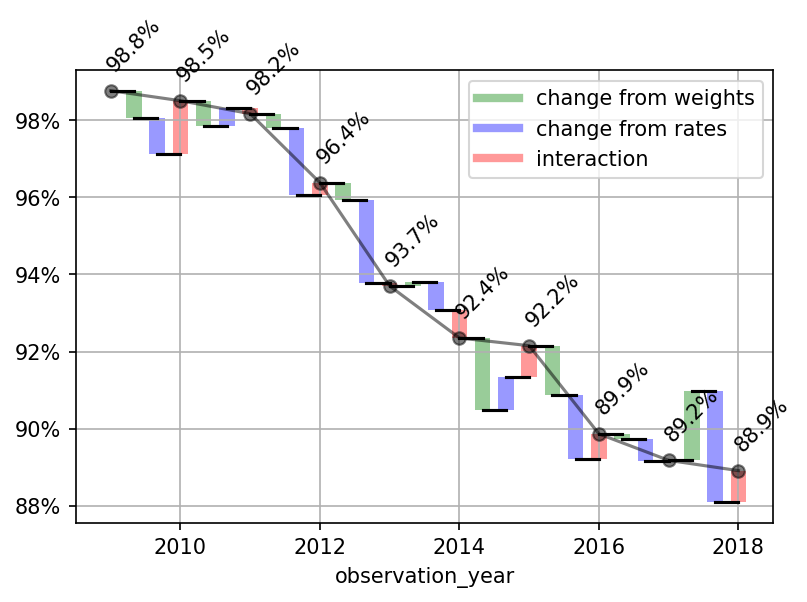

In [29]:
rf0.waterfall();

## Rollforward for certain products

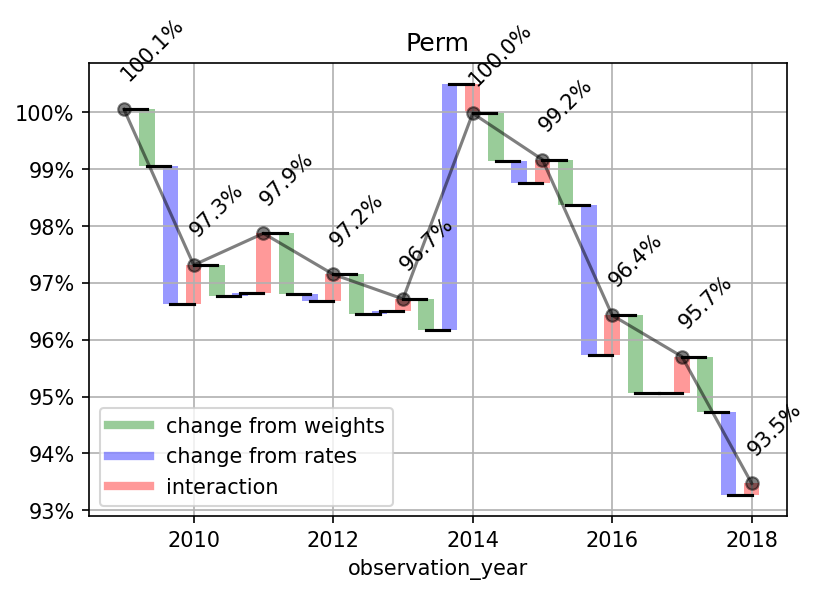

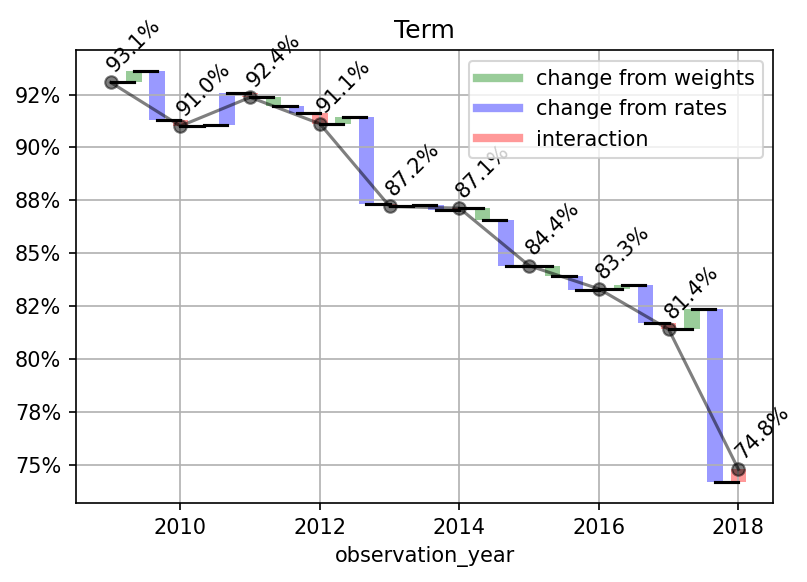

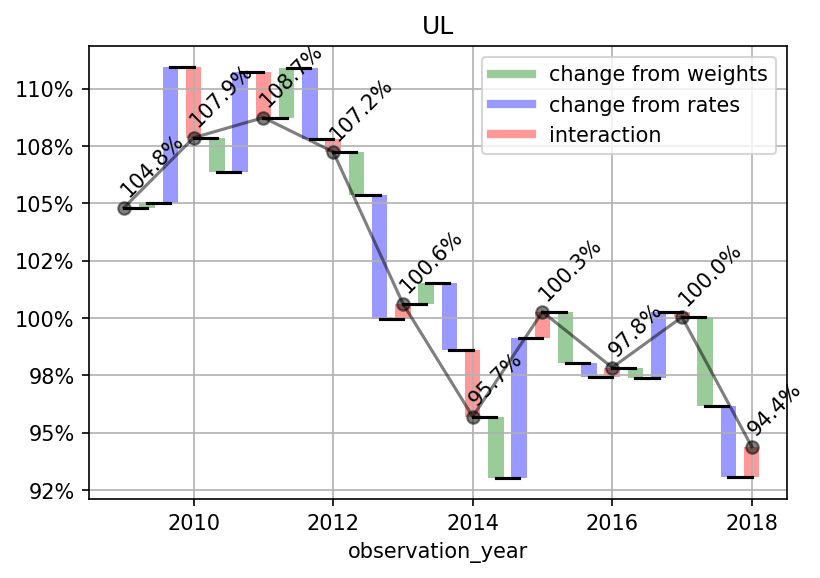

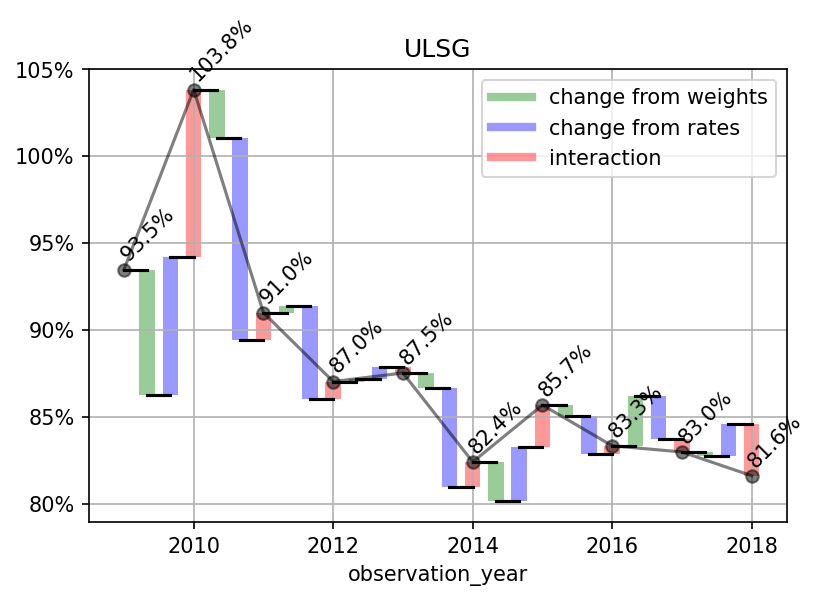

In [35]:
rf_prod = {}
import matplotlib.pyplot as plt
for _product in ['Perm', 'Term', 'UL', 'ULSG']:
    rf_prod[_product] = Rollforward(_product,
                                    datsumm[datsumm.insurance_plan==_product], 
                                    ilectools.rollforward.cols_valact_rf)
    rf_prod[_product].waterfall();
    plt.gca().set_title(_product); # suppress figures

# Anomaly detection

In [16]:
datsumm.head()

,observation_year,issue_age,soa_post_level_term_indicator,insurance_plan,gender,duration,smoker_status,amount_2015vbt,amount_actual,amount_exposure,policy_2015vbt,policy_actual,policy_exposure
0,2009,18,N/A (Not Term),Other,Female,2,NonSmoker,23.227398,0.0,86027.400000,0.000232,0,0.860274
1,2009,18,N/A (Not Term),Other,Female,3,NonSmoker,30.772602,0.0,113972.600000,0.000308,0,1.139726
2,2009,18,N/A (Not Term),Other,Female,28,Unknown,31.733500,0.0,27122.649275,0.001266,0,1.082192
3,2009,18,N/A (Not Term),Other,Female,29,Unknown,63.911173,0.0,50723.152842,0.002503,0,1.986300
4,2009,18,N/A (Not Term),Other,Female,30,Unknown,44.693705,0.0,33106.448414,0.002142,0,1.586302


In [19]:
datsumanom = data.pivot_table(index='observation_year,insurance_plan,smoker_status,face_amount_band,issue_age'.split(','),
                              values='amount_exposure',
                              aggfunc=np.sum)

In [24]:
pt = datsumanom.loc[slice(2009, 2016)].unstack(0).T.fillna(0)

In [34]:
A = pt.div(pt.sum(axis=1), axis=0) # distribution among buckets within each year
Ac = A.sub(A.mean(), axis=1) # centered: subtract mean distriution among buckets

In [36]:
u,s,vh = np.linalg.svd(A, full_matrices=False)

<AxesSubplot:xlabel='0'>

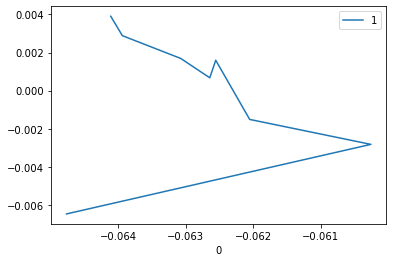

In [40]:
pd.DataFrame(u.dot(np.diag(s)), index=pt.index).plot(x=0, y=1)